## Описание задачи

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов.

## Исследование данных

In [1]:
import pandas as pd

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col = 0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

print('Звонки')
print(calls.head())
print()
print('Интернет')
print(internet.head())
print()
print('Сообщения')
print(messages.head())
print()
print('Тарифы')
print(tariffs.head())
print()
print('Пользователи')
print(users.head())

Звонки
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

Интернет
       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000

Сообщения
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000

Тарифы
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0     

In [2]:
print('Звонки')
calls.info()
print()
print('Интернет')
internet.info()
print()
print('Сообщения')
messages.info()
print()
print('Тарифы')
tariffs.info()
print()
print('Пользователи')
users.info()

Звонки
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Интернет
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB

Сообщения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Тарифы
<class 'pandas.core.frame.DataFrame'>
RangeI

In [3]:
if len(users.groupby(['first_name','last_name'], as_index = False)) == len(users):
    print('Все пользователи разные')
    
# Бывают путают фамилию и имя местами
if len(users.merge(users, left_on = 'first_name', right_on = 'last_name')) == 0:
    print('Нет перепутанных')

if users['city'].apply(lambda x: str.upper(x)).nunique() == users['city'].nunique():
    print('Города прописаны корректно')    

print('Пустых звонков:',str.format('{:.2%}',len(calls[calls.duration == 0])/len(calls)))

Все пользователи разные
Нет перепутанных
Города прописаны корректно
Пустых звонков: 19.55%


### Вывод

Пустые значения только в дате смены тарифа. Заменю на 0. Все даты - строки, необходимо перевести в реальную дату. В остальном типы проставлены адекватно. Цифровые значения также вполне адекватны. Города прописаны корректно, без дублей. ФИО все разные. Также имеет смысл сгруппировать в разрезе пользователя и месяца всю информацию и объединить в одну таблицу. 

Время разговора нужно округлить. 

Разговор нулевой длины - это, возможно, просто ошибка данных, может были проблемы со связью и она обрывалось, могли ещё быть какие-то причины. Явно нельзя сказать 0 должен быть или нет, вообще ошибка ли это, поэтому не могу заполнить их средней, медианой. Но в таком случае, они явно будут влиять на статистические показатели, так как их 20% от всей выборки, поэтому проще их вообще не учитывать в расчётах. Полезная информация в них была бы, если бы точно было известна природа таких значений. К примеру, если бы точно было известно что это проблемы со связью, можно было посчитать стабильность связи по городам.

Размер траффика перевести в Гб

## Предобработка данных

In [4]:
import datetime as dt
import numpy as np
# Заполняю пустые даты
users.fillna(0, inplace = True)

# Округляю звоник до целых в большую сторону
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)

# Траффик в Гб
# так как ceil округляет до верхнего целого, а точность нужна до 3 знаков после запятой,
# то нужно 3 знака после запятой вывести в целое, округлить, а потом снова перевести в нужный разряд 
internet['mb_used_gb'] = np.ceil(1000*internet['mb_used']/1024)/1000
#Вычислить месяц дат
calls['month'] = pd.to_datetime(calls['call_date'],format = '%Y-%m-%d')
calls['month'] = calls['month'].dt.month

internet['month'] = pd.to_datetime(internet['session_date'],format = '%Y-%m-%d')
internet['month'] = internet['month'].dt.month

messages['month'] = pd.to_datetime(messages['message_date'],format = '%Y-%m-%d')
messages['month'] = messages['month'].dt.month

users['reg_month'] = pd.to_datetime(users['reg_date'],format = '%Y-%m-%d')

# в теории дата регистрации может быть не 2018
users['reg_year'] = users['reg_month'].dt.year
users['reg_month'] = users['reg_month'].dt.month
users['churn_month'] = pd.to_datetime(users['churn_date'],format = '%Y-%m-%d', errors='ignore')
users['churn_year'] = users.apply(lambda x: x['churn_month'].year if x['churn_month'].year != 1970 else 0 ,axis=1)
users['churn_month'] = users.apply(lambda x: x['churn_month'].month if x['churn_month'].year != 1970 else 0 ,axis=1)

# группирую возраст 
def age_group(x):
    if x<21:
        return('0-20')
    elif 21<=x<=35:
        return('21-35')
    elif 36<=x<=50:
        return('36-50')
    elif 51<=x<=65:
        return('51-65')
    else:
        return('>66')
        
users['age_group'] = users.apply(lambda x: age_group(x['age'])  ,axis=1)

In [5]:
# группирую данные
gr_calls = calls.query('duration != 0').groupby(['month','user_id'], as_index = False, group_keys=False).agg({'duration':['sum','count']})
gr_messages = messages.groupby(['month','user_id'], as_index = False, group_keys=False).agg({'id':['count']})
gr_internet = internet.groupby(['month','user_id'], as_index = False, group_keys=False).agg({'mb_used_gb':['sum']})

# сливаю всё в одну общую таблицу
all_data = pd.merge(left = gr_calls, right = gr_messages , on = ['user_id','month'], how = 'outer' )
all_data = pd.merge(left = all_data, right = gr_internet , on = ['user_id','month'], how = 'outer' )

all_data.fillna(0, inplace = True)
# после группировки появился мультииндекс по колонкам 
# , что бы избавиться назначаю новые названия
# обшарив интернет, другого простого метода я не нашёл. вылезает предупреждение, ну и пусть
all_data.columns = ['month','user_id','duration_sum','duration_count','messages_count','mb_used_gb_sum']

all_data = pd.merge(left = all_data, right = users[['user_id', 'city', 'tariff', 'age_group', 'churn_month']] , on = 'user_id')
all_data  = pd.merge(left = all_data, right = tariffs, left_on = 'tariff', right_on = 'tariff_name')

def summ(x):
    # rub_monthly_fee — ежемесячная абонентская плата в рублях
    # minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    # messages_included — количество сообщений в месяц, включённых в абонентскую плату
    # mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    # rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    # rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    # rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
    s = x.rub_monthly_fee + max(0,x.duration_sum - x.minutes_included)*x.rub_per_minute 
    s += max(0,x.messages_count - x.messages_included)*x.rub_per_message 
    s += max(0,x.mb_used_gb_sum - np.round(x.mb_per_month_included/1024,3))*x.rub_per_gb
    return s

all_data['summa'] = all_data.apply(lambda x: summ(x)  ,axis=1)
all_data['duration_sum'] = all_data['duration_sum'].astype(int)
all_data['duration_count'] = all_data['duration_count'].astype(int)
all_data['messages_count'] = all_data['messages_count'].astype(int)
all_data

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,month,user_id,duration_sum,duration_count,messages_count,mb_used_gb_sum,city,tariff,age_group,churn_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,summa
0,1,1005,95,11,7,2.668,Набережные Челны,smart,>66,0,50,15360,500,550,200,3,3,smart,550.00
1,2,1005,456,55,38,7.221,Набережные Челны,smart,>66,0,50,15360,500,550,200,3,3,smart,550.00
2,3,1005,606,63,56,10.859,Набережные Челны,smart,>66,0,50,15360,500,550,200,3,3,smart,886.00
3,4,1005,712,77,41,9.144,Набережные Челны,smart,>66,0,50,15360,500,550,200,3,3,smart,1186.00
4,5,1005,595,62,42,7.691,Набережные Челны,smart,>66,0,50,15360,500,550,200,3,3,smart,835.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,11,1473,0,0,14,21.185,Красноярск,ultra,0-20,0,1000,30720,3000,1950,150,1,1,ultra,1950.00
3210,12,1473,0,0,20,18.002,Красноярск,ultra,0-20,0,1000,30720,3000,1950,150,1,1,ultra,1950.00
3211,10,1328,0,0,6,21.923,Мурманск,ultra,36-50,0,1000,30720,3000,1950,150,1,1,ultra,1950.00
3212,11,1328,0,0,8,34.725,Мурманск,ultra,36-50,0,1000,30720,3000,1950,150,1,1,ultra,2658.75


### Вывод

Собрал все данные в одну таблицу. Вычислил нужные показатели. Так как нет сложных связей, типа один и тот же клиент находился в разные периоды в разных городах, или разные периоды использования тарифов, то данная таблица адекватно отображает сводную информацию. Эти данные избыточны для задач в условии, но с такой таблицей можно гораздо больше сделать, при необходимости.

## Исследовательский анализ данных

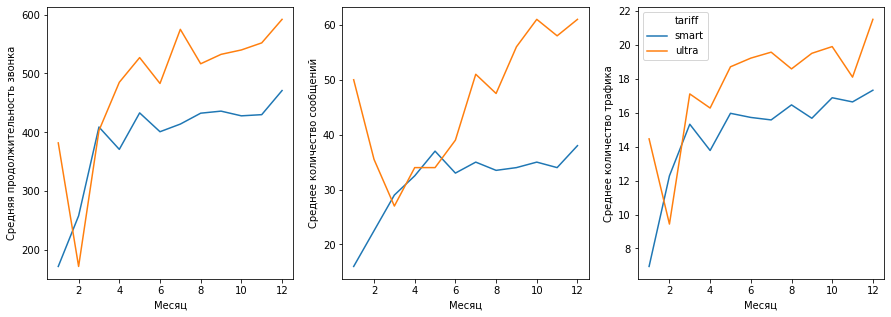

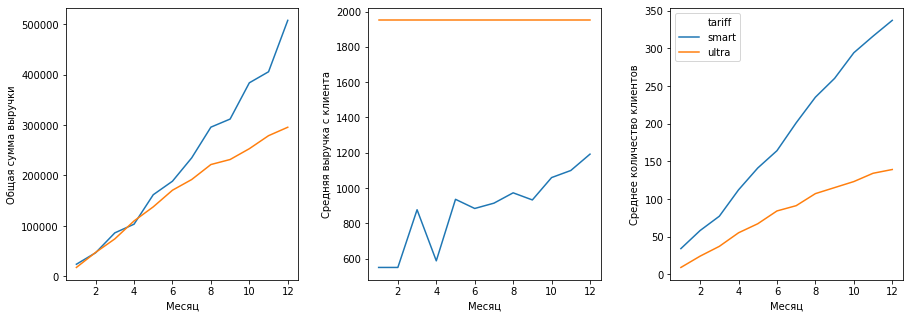

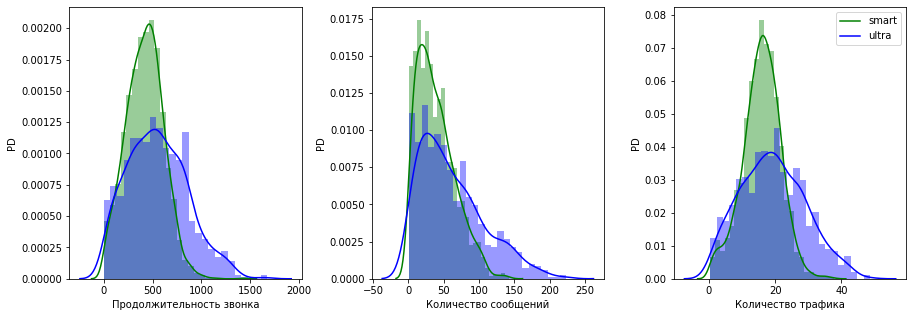

Статистические показатели:
Звонки :
    Тариф: smart
         Дисперсия: 35718.13  Ср. откл.: 188.99  Среднее: 419.44
         Распределение не нормальное
    Тариф: ultra
         Дисперсия: 93338.43  Ср. откл.: 305.51  Среднее: 547.76
         Распределение не нормальное
Сообщения :
    Тариф: smart
         Дисперсия: 717.59  Ср. откл.: 26.79  Среднее: 38.72
         Распределение не нормальное
    Тариф: ultra
         Дисперсия: 2109.66  Ср. откл.: 45.93  Среднее: 61.16
         Распределение не нормальное
Трафик :
    Тариф: smart
         Дисперсия: 32.75  Ср. откл.: 5.72  Среднее: 15.86
         Распределение не нормальное
    Тариф: ultra
         Дисперсия: 94.18  Ср. откл.: 9.7  Среднее: 19.25
         Распределение не нормальное


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import matplotlib.lines as mlines


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(ax = axes[0], legend=False, x="month", y="duration_sum", data=all_data[all_data.duration_sum > 0].groupby(['month','tariff'], as_index = False).duration_sum.median(), hue = 'tariff')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Средняя продолжительность звонка')
sns.lineplot(ax = axes[1], legend=False, x="month", y="messages_count", data=all_data[all_data.messages_count > 0].groupby(['month','tariff'], as_index = False).messages_count.median(), hue = 'tariff')
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Среднее количество сообщений')
sns.lineplot(ax = axes[2], x="month", y="mb_used_gb_sum", data=all_data[all_data.mb_used_gb_sum > 0].groupby(['month','tariff'], as_index = False).mb_used_gb_sum.median(), hue = 'tariff')
axes[2].set_xlabel('Месяц')
axes[2].set_ylabel('Среднее количество трафика')
plt.subplots_adjust(wspace= 0.2)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(ax = axes[0], legend=False, x="month", y="summa", data=all_data.groupby(['month','tariff'], as_index = False).summa.sum(), hue = 'tariff')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Общая сумма выручки')

sns.lineplot(ax = axes[1], legend=False, x="month", y="summa", data=all_data.groupby(['month','tariff'], as_index = False).summa.median(), hue = 'tariff')
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Средняя выручка с клиента')

sns.lineplot(ax = axes[2], x="month", y="summa", data=all_data.groupby(['month','tariff'], as_index = False).summa.count(), hue = 'tariff')
axes[2].set_xlabel('Месяц')
axes[2].set_ylabel('Среднее количество клиентов')
plt.subplots_adjust(wspace= 0.3)
plt.show()

# Данная структура для автоматизации вывода статистичесих данных
d1 = {}
d1['smart'] = all_data[(all_data.tariff == 'smart') & (all_data.duration_sum > 0)].duration_sum
d1['ultra'] = all_data[(all_data.tariff != 'smart') & (all_data.duration_sum > 0)].duration_sum
d2 = {}
d2['smart'] = all_data[(all_data.tariff == 'smart') & (all_data.messages_count > 0)].messages_count
d2['ultra'] = all_data[(all_data.tariff != 'smart') & (all_data.messages_count > 0)].messages_count
d3 = {}
d3['smart'] = all_data[(all_data.tariff == 'smart') & (all_data.mb_used_gb_sum > 0)].mb_used_gb_sum
d3['ultra'] = all_data[(all_data.tariff != 'smart') & (all_data.mb_used_gb_sum > 0)].mb_used_gb_sum

d = {'Звонки':d1,'Сообщения':d2,'Трафик':d3}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(d['Звонки']['smart'], bins=25,ax = axes[0], color="g")
sns.distplot(d['Звонки']['ultra'], bins=25, ax = axes[0],color="b")
axes[0].set_xlabel('Продолжительность звонка')
axes[0].set_ylabel('PD')

sns.distplot(d['Сообщения']['smart'], bins=25,ax = axes[1], color="g")
sns.distplot(d['Сообщения']['ultra'], bins=25,ax = axes[1], color="b")
axes[1].set_xlabel('Количество сообщений')
axes[1].set_ylabel('PD')

sns.distplot(d['Трафик']['smart'], bins=25,ax = axes[2], color="g")
sns.distplot(d['Трафик']['ultra'], bins=25,ax = axes[2], color="b")
axes[2].set_xlabel('Количество трафика')
axes[2].set_ylabel('PD')

blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='ultra')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='smart')
plt.legend(handles=[green_line,blue_line])
plt.subplots_adjust(wspace= 0.3)

plt.show()

print("Статистические показатели:")
for i in d:
    print(i,':')
    for j in d[i]:
        print('    Тариф: '+j)
        q = d[i][j].describe()        
        print('        ','Дисперсия: '+ str(np.round(q['std']**2,2)),' Ср. откл.: '+ str(np.round(q['std'],2)),' Среднее: '+ str(np.round(q['mean'],2)))
        if scipy.stats.shapiro(d[i][j])[1] <0.05:
            print('        ', 'Распределение не нормальное')   


### Вывод

Распределение в основном ассимитричны. Продолжительность звонка ещё и очень широкая, поэтому имеет огромную дисперсию. Распределения не соответствует нормальному, так как провалился тест Шапиро - Уилка.

Также явно видно, что на тарифе ультра выше средняя продолжительность звонка, отправляется больше сообщений, выше трафик, при этом отрыв от смарта произошёл с апреля - мая, до этого либо примерно равны, либо меньше чам тариф смарт.

Стоит заметить, что средняя выручка клиента у тарифа ультра равна абонентской плате, а это значит что люди не успевают истратить весь бесплатный пакет. Люди это прекрасно понимают и подключаются к смарту, что бы не переплачивать. Это видно по динамке роста количества клиентов, а из за этого выручка со смарта больше, даже при условии что средняя выручка с клиента в разы меньше. Это говорит, что смарт более выгодный тариф чем ультра, так как общая выручка с него больше, при меньших затратах. 

## Проверка гипотез

In [7]:

# средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
from scipy import stats as st
alpha = 0.05

# Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
# t-тест можно делать если:
# Сравниваемые значения не составляют пару коррелирующих значений
# Дисперсии признака в выборках примерно равны
# нормальное распределение на больших выборках не является обязательным условиям
# корреляции тут явно нет, так как априори независимые выборки
# Дисперсию проверю по критерию Фишера

d1 = all_data.query('tariff != "smart"').summa
d2 = all_data.query('tariff == "smart"').summa
print('Критерий Фишера:',np.var(d2)/np.var(d1))

Критерий Фишера: 4.889817669765416


In [8]:
# Этот показатель означает, что дисперсии сильно отличаются.
# В таком случае нельзя делать t тест. Можно сделать U-критерий Манна-Уитни
results =  scipy.stats.mannwhitneyu(d1,d2)

if results.pvalue < alpha:
    print('Средняя выручка тарифов отличается')
else:
    print('Средняя выручка тарифов не отличается')



Средняя выручка тарифов отличается


In [9]:
    
# Гипотеза: средняя выручка пользователей тарифов в Москве не отличается от выручки в других регионах
# Рассуждения такие же как и выше 

d1 = all_data.query('city != "Москва"').summa
d2 = all_data.query('city == "Москва"').summa
print('Критерий Фишера:',np.var(d2)/np.var(d1))


Критерий Фишера: 0.8668160789651265


In [10]:
#А вот здесь можно провести t-тест
results =  scipy.stats.ttest_ind(d1,d2)

if results.pvalue < alpha:
    print('Средняя выручка по Москве отличается от остальных регионов')
else:
    print('Средняя выручка по Москве не отличается от остальных регионов')


Средняя выручка по Москве не отличается от остальных регионов


### Вывод

Сделан достаточно очевидный вывод, что выручка у разных тарифах разная. Также сделан вывод, что в Москве примерно такая же выручка как и вне Москвы. Это значит что в Москве примерно такая же пропорция людей с разными тарифами, примерно столько же разговаривают, сёрфят и переписываются.

## Общий вывод

По факту на тарифе смарт основная часть клиентов используют практически весь бесплатный лимит, иногда его превышая, для тарифа ультра клиенты не успевают потратить весь бесплатный пакет услуг, более того разговаривают, пишут, качают они не сильно больше чем на смарт, из-за этого они не понимаю за что платят, ведь тоже самое (может чуть урезанное) и намного дешевле есть на смарте, и с их точки зрения смарт более выгодный, что показывает динамика роста клиентов. 

К примеру, на смарте средний трафик ~16 гб, на ультра ~19 гб. Казалось бы перейти на ультра выгодно, ведь если на смарте выкачивать такой трафик, то это 500р + 200р * 4 = 1300, что не мало, а на ультра ещё больше можно использовать. Но в реальности у почти всех дома есть интерент, можно купить wi fi (а то и провайдер сам отдаст), платить 900 руб за безлимит. Если в семье несколько людей, то экономия в разы превышает все щедрые предложения тарифа ультра. Не говоря, что и звонить и писать также можно через интернет.

Поэтому много людей берут именно тариф смарт, а из-за за этого выручка у него больше, а значит данный тариф лучше для массового клиента. 